# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)

df = pd.read_csv(data_folder + 'aapl.csv')
df = df.iloc[:, 1:]
df

,Open,High,Low,Close,Volume,Close_SMA10,Close_SMA20,Close_SMA30,Close_EMA10,Close_EMA20,...,Close_long,Close_MACD,Close_SignalLine,Close_7D,Close_1D,Close_Momentum,Close1diff,Close_up,Close_down,Close_RSI
0,151.78,151.78,151.78,151.78,195.0,151.802,151.8685,151.851000,151.814923,151.837962,...,151.846566,-0.025605,-0.016996,151.80,151.80,0.000000,-0.02,0.00,-0.02,37.096774
1,151.78,151.78,151.78,151.78,465.0,151.803,151.8640,151.846333,151.808574,151.832442,...,151.841635,-0.026976,-0.018992,151.80,151.78,-0.000132,0.00,0.00,0.00,33.898305
2,151.75,151.75,151.65,151.69,1877.0,151.787,151.8525,151.837333,151.787015,151.818876,...,151.830403,-0.034922,-0.022178,151.81,151.78,-0.000198,-0.09,0.00,-0.09,28.358209
3,151.62,151.62,151.60,151.62,913.0,151.769,151.8365,151.826667,151.756648,151.799935,...,151.814817,-0.046334,-0.027009,151.81,151.69,-0.000790,-0.07,0.00,-0.07,29.687500
4,151.66,151.66,151.65,151.65,441.0,151.754,151.8210,151.824000,151.737258,151.785656,...,151.802609,-0.052353,-0.032078,151.81,151.62,-0.001252,0.03,0.03,0.00,22.413793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66784,166.28,166.33,166.28,166.33,1020.0,166.340,166.3450,166.359333,166.323779,166.337186,...,166.336513,-0.007955,0.005171,166.40,166.28,-0.000721,0.05,0.05,0.00,51.162791
66785,166.33,166.33,166.30,166.30,327.0,166.325,166.3450,166.351333,166.319455,166.333645,...,166.333808,-0.009644,0.002208,166.33,166.33,0.000000,-0.03,0.00,-0.03,42.307692
66786,166.30,166.35,166.30,166.35,3435.0,166.323,166.3500,166.349333,166.325009,166.335203,...,166.335008,-0.006868,0.000393,166.40,166.30,-0.000601,0.05,0.05,0.00,45.121951
66787,166.33,166.40,166.33,166.40,1519.0,166.323,166.3515,166.348667,166.338644,166.341374,...,166.339822,-0.000627,0.000189,166.35,166.35,0.000000,0.05,0.05,0.00,47.674419


### If you want Feature Engineering for uni-stock

In [4]:
#Feature Engineering Class 
class FeatureEngineering:
    def __init__(self, stock_name):
        self.stock_name = stock_name

    #Simple Moving Average
    def SMA(self,  data, column='Close', period=30):
        data = copy.deepcopy(data)
        data[column+f'_SMA{period}'] = data[column].rolling(period).mean()
        return data
    
    def SMA_(self,  data, column='Close', period=30):
        data = copy.deepcopy(data)
        return data[column].rolling(period).mean()

    #Exponential Moving Average
    def EMA(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        data[column+f'_EMA{period}'] = data[column].ewm(span=period, adjust=False).mean()
        return data
    
    def EMA_(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        return data[column].ewm(span=period, adjust=False).mean()
    
    #BollingerBand with SMA
    def Bollingerband(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+f'_SMA{period}'] = self.SMA_(data, column=column, period=period)
        data[column+'_UB'] = data[column+f'_SMA{period}'] + 2*data[column+f'_SMA{period}'].std()
        data[column+'_LB'] = data[column+f'_SMA{period}'] - 2*data[column+f'_SMA{period}'].std()
        
        return data
    
    #MACD
    def MACD(self, data, period_long=26, period_short=12, period_signal=9, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+'_short'] = self.EMA_(data, period=period_short, column=column)

        data[column+f'_long'] = self.EMA_(data, period=period_long, column=column)

        data[column+'_MACD'] = data[column+f'_short']- data[column+f'_long']

        #signal
        data[column+'_SignalLine'] = self.EMA_(data, period=period_signal, column=column+'_MACD')

        return data
    
    #Momentum
    def Momentum(self, data, period=7, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+f'_{period}D'] = data[column].shift(period)
        data[column+'_1D'] = data[column].shift(1)
        data[column+'_Momentum'] = data[column+'_1D'] / data[column+f'_{period}D'] - 1
        
        return data
    
    #RSI
    def RSI(self, data, period=14, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+'1diff'] = data[column].diff(1)
        
        delta = data[column].diff(1)
        delta = delta.dropna()

        up = delta.copy()
        down = delta.copy()
        up[up<0] = 0
        down[down>0] = 0
        data[column+'_up'] = up
        data[column+'_down'] = down

        AVG_Gain = self.SMA_(data, period=period, column=column+'_up')
        AVG_Loss = abs(self.SMA_(data, period=period, column=column+'_down'))
        RS = AVG_Gain / AVG_Loss

        RSI = 100.0 - (100.0/(1.0+RS))
        data[column+'_RSI'] = RSI
  
        return data
    
    #Get feature engineered data
    def get_data(self, train):
        #print('Feature Engineering...')
        
        self.train = copy.deepcopy(train)
        c = self.stock_name
        
        self.train = self.SMA(self.train, column=c, period=10)
        self.train = self.SMA(self.train, column=c, period=20)
        self.train = self.SMA(self.train, column=c, period=30)
        
        self.train = self.EMA(self.train, column=c, period=10)
        self.train = self.EMA(self.train, column=c, period=20)
        self.train = self.EMA(self.train, column=c, period=30)
        
        self.train = self.Bollingerband(self.train, column=c)
        self.train = self.MACD(self.train, column=c)
        self.train = self.Momentum(self.train, column=c)
        self.train = self.RSI(self.train, column=c)
        
        #print("Done!")
        
        return self.train

In [5]:
#fe = FeatureEngineering('AAPL')
#df_fe = fe.get_data(df.loc[:, ['AAPL']])

In [6]:
#df = pd.concat([df_fe.iloc[:, 1:], df], axis=1)
#df.dropna(inplace=True)
target_loc = pd.Index(df.columns.tolist()).get_loc('Close')
print(target_loc, len(df.columns))

3 24


In [7]:
train = df[:60000]
valid = df[60000:60000+3800]
test = df[60000+3800:]

print(len(train), len(valid), len(test))

sc = MinMaxScaler()
sc.fit(train.values)
train_sc = pd.DataFrame(sc.transform(train.values), columns=df.columns)
valid_sc = pd.DataFrame(sc.transform(valid.values), columns=df.columns)
test_sc = pd.DataFrame(sc.transform(test.values), columns=df.columns)

60000 3800 2989


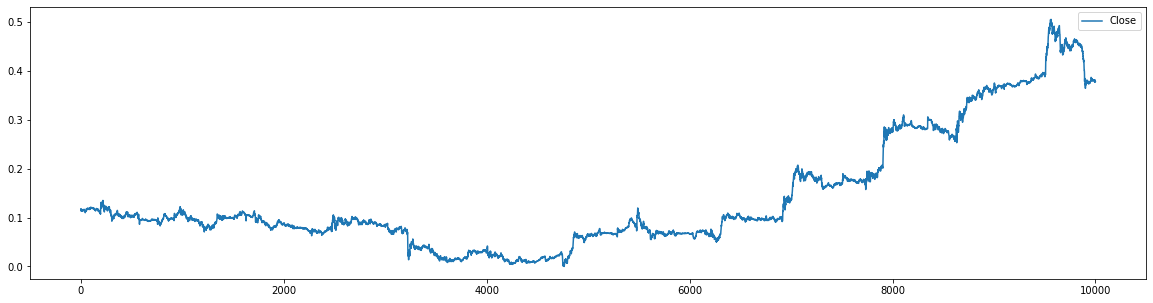

In [8]:
plt.figure(figsize=(20,5))
plt.plot(train_sc.iloc[:10000, target_loc], label=train_sc.columns[target_loc])
plt.legend()
plt.show()

In [9]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, window, pred, target_loc):
        self.data = torch.Tensor(data.values)
        self.window = window
        self.pred = pred
        self.target_loc = target_loc
        self.use_cols = [x for x in range(len(data.columns)) if x != target_loc] #if x != target_loc
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window, self.use_cols]
        y = self.data[index+self.window+self.pred-1, self.target_loc]
        return x, y

    def __len__(self):
        return len(self.data) - self.window - self.pred
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape) # row, col
    
    def __getsize__(self):
        return (self.__len__())

In [11]:
batch_size = 64
num_workers = 4
pin_memory = True
device = 'cuda'
num_epoch = 200
lr = 1e-4
window = 60
pred_step = 10

In [12]:
train_dataset = MyDataset(train_sc, window, pred_step, target_loc)
valid_dataset = MyDataset(valid_sc, window, pred_step, target_loc)
test_dataset = MyDataset(test_sc, window, pred_step, target_loc)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# 2. CNN Model (similar architecture w DynamicRouting CapsNet)

In [13]:
result_folder = f'../check/cnn/stock_prediction_{pred_step}_aapl/'
os.makedirs(result_folder, exist_ok=True)

In [14]:
class CNN(nn.Module):
    def __init__(self, in_features, out_features, pool_size, hidden_dim, capsule_num):
        super().__init__()
        self.output = out_features
        self.pool_size = pool_size
        
        self.hidden_dim = hidden_dim
        self.capsule_num = capsule_num
        
        self.conv1 = nn.Conv2d(in_features, self.hidden_dim, kernel_size=(9, 1), stride=1)
        #self.pool1 = nn.MaxPool2d((1, self.pool_size),1)
        
        self.conv2 = nn.Conv2d(self.hidden_dim, self.hidden_dim, kernel_size=(9, 1), stride=(2,1))
        #self.pool2 = nn.MaxPool2d((1, self.pool_size),1)
        
        self.conv3 = nn.Conv2d(self.hidden_dim, 5*capsule_num*2, kernel_size=(1,1), stride=1)
        self.pool3 = nn.AdaptiveMaxPool2d(1)
       
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(5*capsule_num*2, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.out = nn.Linear(1024, out_features)

    def forward(self, x):
        x = F.relu(self.conv1(x.transpose(1,2).unsqueeze(-1)))# 2. CNN Model (similar architecture w DynamicRouting CapsNet)
        x = F.relu(self.conv2(x))
        x = F.relu(self.pool3(self.conv3(x)))
        
        x = self.flatten(x).unsqueeze(1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.out(x))
        
        return x

In [15]:
model = CNN(in_features= 24-1,
            out_features=1, #classifcation = 5
            pool_size=3, hidden_dim = 256, capsule_num=8).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.MSELoss()

In [16]:
model

CNN(
  (conv1): Conv2d(23, 256, kernel_size=(9, 1), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(9, 1), stride=(2, 1))
  (conv3): Conv2d(256, 80, kernel_size=(1, 1), stride=(1, 1))
  (pool3): AdaptiveMaxPool2d(output_size=1)
  (flatten): Flatten()
  (fc1): Linear(in_features=80, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=1, bias=True)
)

# Model Training & Evaluation #

In [17]:
train_loss_list = []
valid_loss_list = []
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x, y) in tqdm(train_loader, leave=False):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x)

        loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    with torch.no_grad():
        for (x, y) in tqdm(valid_loader, leave=False):
            x = x.to(device)
            y = y.to(device)
            answers.extend(y.detach().cpu().numpy())

            outputs = model(x)

            loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch, num_epoch, train_loss, valid_loss
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    """
    if epoch % 20 ==0 :       
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swcapsule-pred-stock-best.pt')s
    """
    
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swcapsule-pred-stock-best.pt')

epoch: 0/200 | trn_loss: 0.0277 | val_loss: 0.0180


epoch: 1/200 | trn_loss: 0.0160 | val_loss: 0.0171


epoch: 2/200 | trn_loss: 0.0149 | val_loss: 0.0166


epoch: 3/200 | trn_loss: 0.0146 | val_loss: 0.0165


epoch: 4/200 | trn_loss: 0.0142 | val_loss: 0.0180


epoch: 5/200 | trn_loss: 0.0139 | val_loss: 0.0156


epoch: 6/200 | trn_loss: 0.0133 | val_loss: 0.0159


epoch: 7/200 | trn_loss: 0.0134 | val_loss: 0.0155


epoch: 8/200 | trn_loss: 0.0132 | val_loss: 0.0167


epoch: 9/200 | trn_loss: 0.0128 | val_loss: 0.0153


epoch: 10/200 | trn_loss: 0.0126 | val_loss: 0.0166


epoch: 11/200 | trn_loss: 0.0127 | val_loss: 0.0150


epoch: 12/200 | trn_loss: 0.0125 | val_loss: 0.0152


epoch: 13/200 | trn_loss: 0.0121 | val_loss: 0.0152


epoch: 14/200 | trn_loss: 0.0121 | val_loss: 0.0167


epoch: 15/200 | trn_loss: 0.0119 | val_loss: 0.0156


epoch: 16/200 | trn_loss: 0.0117 | val_loss: 0.0174


epoch: 17/200 | trn_loss: 0.0116 | val_loss: 0.0151


epoch: 18/200 | trn_loss: 0.0115 | val_loss: 0.0163


epoch: 19/200 | trn_loss: 0.0116 | val_loss: 0.0162


epoch: 20/200 | trn_loss: 0.0113 | val_loss: 0.0156


epoch: 21/200 | trn_loss: 0.0112 | val_loss: 0.0156


epoch: 22/200 | trn_loss: 0.0112 | val_loss: 0.0167


epoch: 23/200 | trn_loss: 0.0111 | val_loss: 0.0168


epoch: 24/200 | trn_loss: 0.0110 | val_loss: 0.0165


epoch: 25/200 | trn_loss: 0.0109 | val_loss: 0.0162


epoch: 26/200 | trn_loss: 0.0109 | val_loss: 0.0160


epoch: 27/200 | trn_loss: 0.0108 | val_loss: 0.0173


epoch: 28/200 | trn_loss: 0.0105 | val_loss: 0.0157


epoch: 29/200 | trn_loss: 0.0104 | val_loss: 0.0186


epoch: 30/200 | trn_loss: 0.0104 | val_loss: 0.0161


epoch: 31/200 | trn_loss: 0.0104 | val_loss: 0.0170


epoch: 32/200 | trn_loss: 0.0103 | val_loss: 0.0162


epoch: 33/200 | trn_loss: 0.0103 | val_loss: 0.0165


epoch: 34/200 | trn_loss: 0.0102 | val_loss: 0.0165


epoch: 35/200 | trn_loss: 0.0100 | val_loss: 0.0165


epoch: 36/200 | trn_loss: 0.0101 | val_loss: 0.0167


epoch: 37/200 | trn_loss: 0.0099 | val_loss: 0.0173


epoch: 38/200 | trn_loss: 0.0099 | val_loss: 0.0165


epoch: 39/200 | trn_loss: 0.0097 | val_loss: 0.0168


epoch: 40/200 | trn_loss: 0.0097 | val_loss: 0.0170


epoch: 41/200 | trn_loss: 0.0098 | val_loss: 0.0170


epoch: 42/200 | trn_loss: 0.0096 | val_loss: 0.0166


epoch: 43/200 | trn_loss: 0.0095 | val_loss: 0.0167


epoch: 44/200 | trn_loss: 0.0094 | val_loss: 0.0168


epoch: 45/200 | trn_loss: 0.0094 | val_loss: 0.0172


epoch: 46/200 | trn_loss: 0.0094 | val_loss: 0.0179


epoch: 47/200 | trn_loss: 0.0094 | val_loss: 0.0178


epoch: 48/200 | trn_loss: 0.0092 | val_loss: 0.0178


epoch: 49/200 | trn_loss: 0.0092 | val_loss: 0.0167


epoch: 50/200 | trn_loss: 0.0091 | val_loss: 0.0170


epoch: 51/200 | trn_loss: 0.0091 | val_loss: 0.0172


epoch: 52/200 | trn_loss: 0.0091 | val_loss: 0.0171


epoch: 53/200 | trn_loss: 0.0090 | val_loss: 0.0175


epoch: 54/200 | trn_loss: 0.0090 | val_loss: 0.0172


epoch: 55/200 | trn_loss: 0.0089 | val_loss: 0.0172


epoch: 56/200 | trn_loss: 0.0088 | val_loss: 0.0176


epoch: 57/200 | trn_loss: 0.0088 | val_loss: 0.0171


epoch: 58/200 | trn_loss: 0.0089 | val_loss: 0.0177


epoch: 59/200 | trn_loss: 0.0086 | val_loss: 0.0171


epoch: 60/200 | trn_loss: 0.0087 | val_loss: 0.0173


epoch: 61/200 | trn_loss: 0.0086 | val_loss: 0.0174


epoch: 62/200 | trn_loss: 0.0085 | val_loss: 0.0172


epoch: 63/200 | trn_loss: 0.0087 | val_loss: 0.0178


epoch: 64/200 | trn_loss: 0.0086 | val_loss: 0.0174


epoch: 65/200 | trn_loss: 0.0084 | val_loss: 0.0173


epoch: 66/200 | trn_loss: 0.0085 | val_loss: 0.0185


epoch: 67/200 | trn_loss: 0.0084 | val_loss: 0.0174


epoch: 68/200 | trn_loss: 0.0084 | val_loss: 0.0175


epoch: 69/200 | trn_loss: 0.0085 | val_loss: 0.0175


epoch: 70/200 | trn_loss: 0.0084 | val_loss: 0.0174


epoch: 71/200 | trn_loss: 0.0082 | val_loss: 0.0176


epoch: 72/200 | trn_loss: 0.0083 | val_loss: 0.0177


epoch: 73/200 | trn_loss: 0.0082 | val_loss: 0.0170


epoch: 74/200 | trn_loss: 0.0083 | val_loss: 0.0180


epoch: 75/200 | trn_loss: 0.0083 | val_loss: 0.0173


epoch: 76/200 | trn_loss: 0.0082 | val_loss: 0.0193


epoch: 77/200 | trn_loss: 0.0080 | val_loss: 0.0184


epoch: 78/200 | trn_loss: 0.0080 | val_loss: 0.0173


epoch: 79/200 | trn_loss: 0.0080 | val_loss: 0.0183


epoch: 80/200 | trn_loss: 0.0081 | val_loss: 0.0181


epoch: 81/200 | trn_loss: 0.0078 | val_loss: 0.0183


epoch: 82/200 | trn_loss: 0.0080 | val_loss: 0.0175


epoch: 83/200 | trn_loss: 0.0079 | val_loss: 0.0179


epoch: 84/200 | trn_loss: 0.0078 | val_loss: 0.0185


epoch: 85/200 | trn_loss: 0.0077 | val_loss: 0.0179


epoch: 86/200 | trn_loss: 0.0078 | val_loss: 0.0179


epoch: 87/200 | trn_loss: 0.0078 | val_loss: 0.0182


epoch: 88/200 | trn_loss: 0.0077 | val_loss: 0.0177


epoch: 89/200 | trn_loss: 0.0076 | val_loss: 0.0182


epoch: 90/200 | trn_loss: 0.0077 | val_loss: 0.0177


epoch: 91/200 | trn_loss: 0.0077 | val_loss: 0.0190


epoch: 92/200 | trn_loss: 0.0076 | val_loss: 0.0179


epoch: 93/200 | trn_loss: 0.0076 | val_loss: 0.0176


epoch: 94/200 | trn_loss: 0.0076 | val_loss: 0.0179


epoch: 95/200 | trn_loss: 0.0077 | val_loss: 0.0182


epoch: 96/200 | trn_loss: 0.0075 | val_loss: 0.0185


epoch: 97/200 | trn_loss: 0.0074 | val_loss: 0.0179


epoch: 98/200 | trn_loss: 0.0075 | val_loss: 0.0184


epoch: 99/200 | trn_loss: 0.0074 | val_loss: 0.0193


epoch: 100/200 | trn_loss: 0.0075 | val_loss: 0.0183


epoch: 101/200 | trn_loss: 0.0074 | val_loss: 0.0180


epoch: 102/200 | trn_loss: 0.0073 | val_loss: 0.0178


epoch: 103/200 | trn_loss: 0.0073 | val_loss: 0.0177


epoch: 104/200 | trn_loss: 0.0073 | val_loss: 0.0178


epoch: 105/200 | trn_loss: 0.0073 | val_loss: 0.0182


epoch: 106/200 | trn_loss: 0.0074 | val_loss: 0.0184


epoch: 107/200 | trn_loss: 0.0072 | val_loss: 0.0181


epoch: 108/200 | trn_loss: 0.0072 | val_loss: 0.0177


epoch: 109/200 | trn_loss: 0.0072 | val_loss: 0.0190


epoch: 110/200 | trn_loss: 0.0072 | val_loss: 0.0177


epoch: 111/200 | trn_loss: 0.0072 | val_loss: 0.0190


epoch: 112/200 | trn_loss: 0.0070 | val_loss: 0.0183


epoch: 113/200 | trn_loss: 0.0071 | val_loss: 0.0178


epoch: 114/200 | trn_loss: 0.0072 | val_loss: 0.0191


epoch: 115/200 | trn_loss: 0.0070 | val_loss: 0.0178


epoch: 116/200 | trn_loss: 0.0071 | val_loss: 0.0180


epoch: 117/200 | trn_loss: 0.0070 | val_loss: 0.0185


epoch: 118/200 | trn_loss: 0.0070 | val_loss: 0.0177


epoch: 119/200 | trn_loss: 0.0071 | val_loss: 0.0180


epoch: 120/200 | trn_loss: 0.0069 | val_loss: 0.0181


epoch: 121/200 | trn_loss: 0.0070 | val_loss: 0.0181


epoch: 122/200 | trn_loss: 0.0069 | val_loss: 0.0192


epoch: 123/200 | trn_loss: 0.0070 | val_loss: 0.0182


epoch: 124/200 | trn_loss: 0.0069 | val_loss: 0.0180


epoch: 125/200 | trn_loss: 0.0069 | val_loss: 0.0178


epoch: 126/200 | trn_loss: 0.0068 | val_loss: 0.0187


epoch: 127/200 | trn_loss: 0.0068 | val_loss: 0.0188


epoch: 128/200 | trn_loss: 0.0068 | val_loss: 0.0186


epoch: 129/200 | trn_loss: 0.0069 | val_loss: 0.0179


epoch: 130/200 | trn_loss: 0.0067 | val_loss: 0.0182


epoch: 131/200 | trn_loss: 0.0067 | val_loss: 0.0182


epoch: 132/200 | trn_loss: 0.0067 | val_loss: 0.0186


epoch: 133/200 | trn_loss: 0.0068 | val_loss: 0.0189


epoch: 134/200 | trn_loss: 0.0066 | val_loss: 0.0184


epoch: 135/200 | trn_loss: 0.0066 | val_loss: 0.0184


epoch: 136/200 | trn_loss: 0.0067 | val_loss: 0.0184


epoch: 137/200 | trn_loss: 0.0066 | val_loss: 0.0181


epoch: 138/200 | trn_loss: 0.0067 | val_loss: 0.0188


epoch: 139/200 | trn_loss: 0.0065 | val_loss: 0.0184


epoch: 140/200 | trn_loss: 0.0066 | val_loss: 0.0187


epoch: 141/200 | trn_loss: 0.0065 | val_loss: 0.0188


epoch: 142/200 | trn_loss: 0.0065 | val_loss: 0.0185


epoch: 143/200 | trn_loss: 0.0066 | val_loss: 0.0185


epoch: 144/200 | trn_loss: 0.0065 | val_loss: 0.0186


epoch: 145/200 | trn_loss: 0.0065 | val_loss: 0.0189


epoch: 146/200 | trn_loss: 0.0064 | val_loss: 0.0189


epoch: 147/200 | trn_loss: 0.0064 | val_loss: 0.0190


epoch: 148/200 | trn_loss: 0.0064 | val_loss: 0.0183


epoch: 149/200 | trn_loss: 0.0064 | val_loss: 0.0186


epoch: 150/200 | trn_loss: 0.0065 | val_loss: 0.0184


epoch: 151/200 | trn_loss: 0.0064 | val_loss: 0.0185


epoch: 152/200 | trn_loss: 0.0063 | val_loss: 0.0197


epoch: 153/200 | trn_loss: 0.0063 | val_loss: 0.0189


epoch: 154/200 | trn_loss: 0.0063 | val_loss: 0.0190


epoch: 155/200 | trn_loss: 0.0063 | val_loss: 0.0190


epoch: 156/200 | trn_loss: 0.0064 | val_loss: 0.0193


epoch: 157/200 | trn_loss: 0.0063 | val_loss: 0.0185


epoch: 158/200 | trn_loss: 0.0064 | val_loss: 0.0188


epoch: 159/200 | trn_loss: 0.0062 | val_loss: 0.0189


epoch: 160/200 | trn_loss: 0.0062 | val_loss: 0.0187


epoch: 161/200 | trn_loss: 0.0062 | val_loss: 0.0187


epoch: 162/200 | trn_loss: 0.0061 | val_loss: 0.0193


epoch: 163/200 | trn_loss: 0.0062 | val_loss: 0.0188


epoch: 164/200 | trn_loss: 0.0062 | val_loss: 0.0187


epoch: 165/200 | trn_loss: 0.0061 | val_loss: 0.0187


epoch: 166/200 | trn_loss: 0.0062 | val_loss: 0.0200


epoch: 167/200 | trn_loss: 0.0060 | val_loss: 0.0187


epoch: 168/200 | trn_loss: 0.0062 | val_loss: 0.0189


epoch: 169/200 | trn_loss: 0.0062 | val_loss: 0.0191


epoch: 170/200 | trn_loss: 0.0060 | val_loss: 0.0190


epoch: 171/200 | trn_loss: 0.0061 | val_loss: 0.0194


epoch: 172/200 | trn_loss: 0.0060 | val_loss: 0.0190


epoch: 173/200 | trn_loss: 0.0061 | val_loss: 0.0191


epoch: 174/200 | trn_loss: 0.0060 | val_loss: 0.0190


epoch: 175/200 | trn_loss: 0.0060 | val_loss: 0.0194


epoch: 176/200 | trn_loss: 0.0061 | val_loss: 0.0191


epoch: 177/200 | trn_loss: 0.0060 | val_loss: 0.0195


epoch: 178/200 | trn_loss: 0.0059 | val_loss: 0.0189


epoch: 179/200 | trn_loss: 0.0059 | val_loss: 0.0196


epoch: 180/200 | trn_loss: 0.0060 | val_loss: 0.0194


epoch: 181/200 | trn_loss: 0.0059 | val_loss: 0.0196


epoch: 182/200 | trn_loss: 0.0060 | val_loss: 0.0201


epoch: 183/200 | trn_loss: 0.0060 | val_loss: 0.0193


epoch: 184/200 | trn_loss: 0.0059 | val_loss: 0.0192


epoch: 185/200 | trn_loss: 0.0059 | val_loss: 0.0192


epoch: 186/200 | trn_loss: 0.0058 | val_loss: 0.0195


epoch: 187/200 | trn_loss: 0.0060 | val_loss: 0.0192


epoch: 188/200 | trn_loss: 0.0058 | val_loss: 0.0192


epoch: 189/200 | trn_loss: 0.0059 | val_loss: 0.0195


epoch: 190/200 | trn_loss: 0.0057 | val_loss: 0.0196


epoch: 191/200 | trn_loss: 0.0058 | val_loss: 0.0193


epoch: 192/200 | trn_loss: 0.0059 | val_loss: 0.0194


epoch: 193/200 | trn_loss: 0.0058 | val_loss: 0.0199


epoch: 194/200 | trn_loss: 0.0057 | val_loss: 0.0196


epoch: 195/200 | trn_loss: 0.0059 | val_loss: 0.0193


epoch: 196/200 | trn_loss: 0.0056 | val_loss: 0.0196


epoch: 197/200 | trn_loss: 0.0057 | val_loss: 0.0193


epoch: 198/200 | trn_loss: 0.0058 | val_loss: 0.0194


epoch: 199/200 | trn_loss: 0.0057 | val_loss: 0.0199


epoch: 200/200 | trn_loss: 0.0057 | val_loss: 0.0194


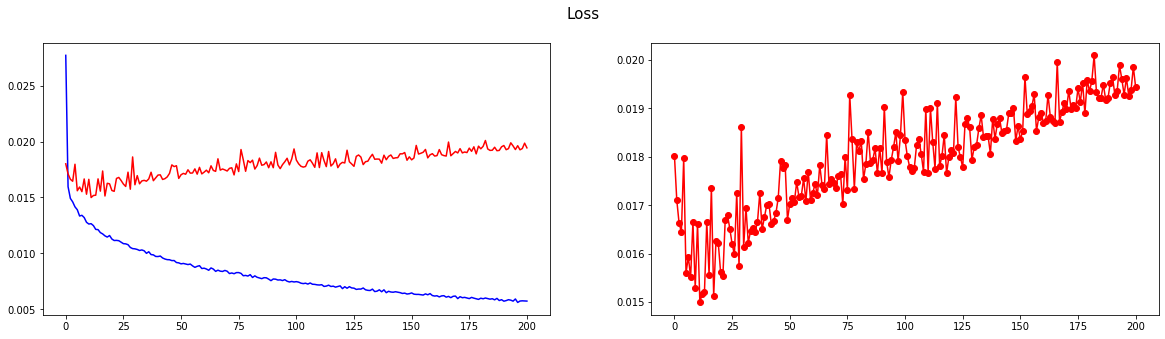

In [18]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'cnn_loss.png')

In [19]:
pd.DataFrame([train_loss_list, valid_loss_list]).to_csv(result_folder + 'cnn_loss.csv', index=0)

### Performance Evaluation

In [20]:
checkpoint = torch.load(result_folder + 'cnn-swcapsule-pred-stock-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'])

11 0.014996228644908485


In [21]:
model = model.eval()
test_loss = []
answers = []
predictions = []

with torch.no_grad():
    for (x, y) in tqdm(test_loader, leave=False):
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        
        loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
        answers.extend((y.squeeze()).squeeze().detach().cpu().numpy())
        predictions.extend((outputs.squeeze()).squeeze().detach().cpu().numpy())
        test_loss.append(loss.item())  
        
test_loss = np.mean(test_loss)
print(f'test loss: {test_loss}')

test loss: 0.012596161631138428


In [23]:
answers = pd.DataFrame(answers)
answers = pd.concat([answers, test_sc.iloc[61:, 1:].reset_index(drop=True)], axis=1)
predictions = pd.DataFrame(predictions)
predictions = pd.concat([predictions, test_sc.iloc[61:, 1:].reset_index(drop=True)], axis=1)
print(answers.shape, predictions.shape, test_sc.shape)

result_ans = pd.DataFrame(sc.inverse_transform(answers), columns = test_sc.columns)
result_pred= pd.DataFrame(sc.inverse_transform(predictions), columns = test_sc.columns)


result_ans.to_csv(result_folder + 'result_ans.csv')
result_pred.to_csv(result_folder + 'result_pred.csv')

(2928, 24) (2928, 24) (2989, 24)


In [24]:
print(result_ans.shape)

(2928, 24)


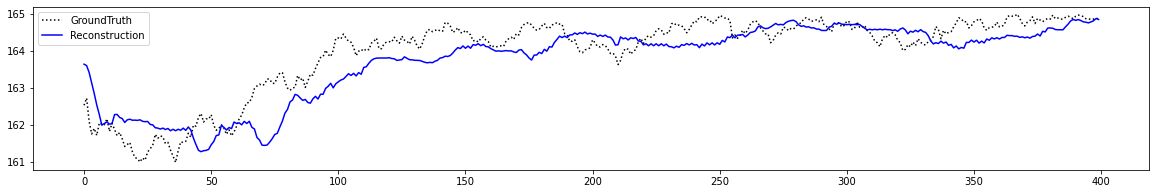

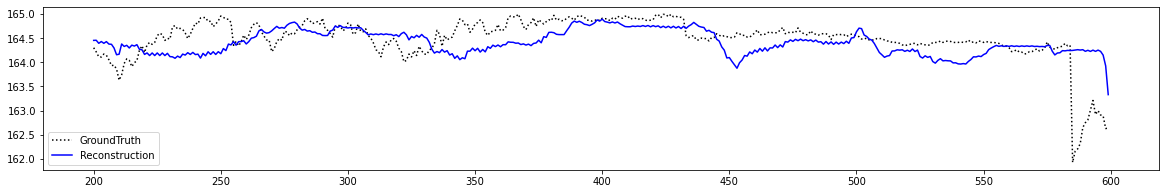

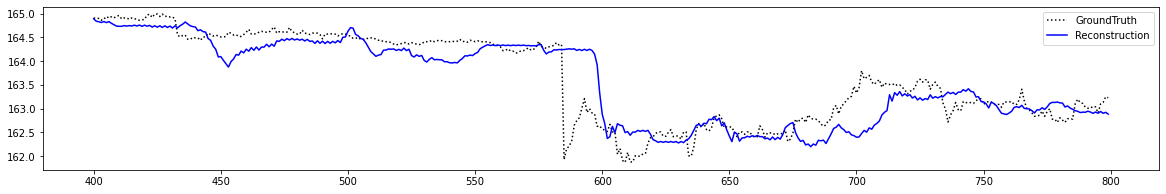

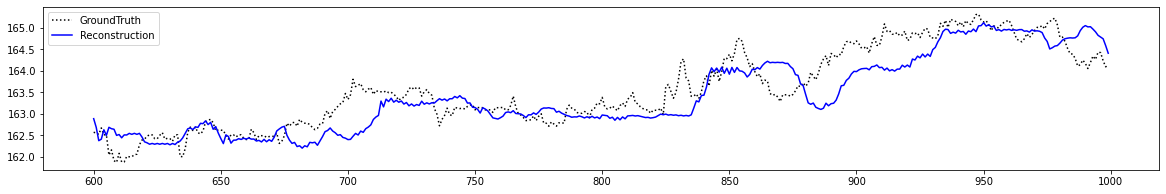

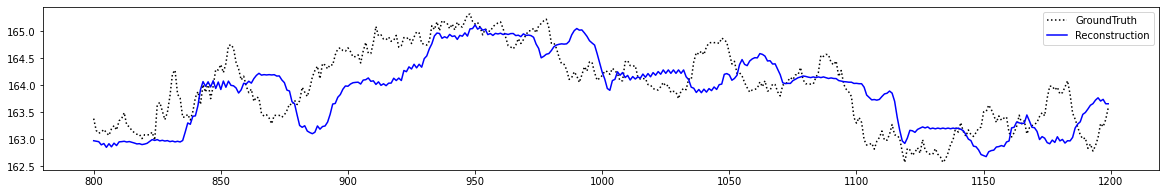

In [25]:
for i in range(0,1000,200):
    plt.figure(figsize=(20,3))
    plt.plot(result_ans.iloc[i:i+400, 0], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_pred.iloc[i:i+400, 0], c='blue', label='Reconstruction')
    plt.legend()
    plt.show()